In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("lm.mplstyle")

import os
import numpy as np
import samplebase as sb
import pandas as pd
import case_config

- 47 rates
- 14 different #realizations
- 10 runs each

In [2]:
case_config.print_config(False)

ReaDDy learn config
*********************************************
Target time: 2.0
Gillespie intermediate rescaling factor: 500.0
Discretization timestep: 0.003


In [3]:
DATA_ROOT = "/home/mho/Dropbox/phd/readdy_learn/reaction_learn_data"
crop_estimated_rates = True
gillespie_realizations = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]

In [4]:
with open(os.path.join(DATA_ROOT, 'case2_validation_alphas_and_solutions_averagefolds.npz'), 'rb') as f:
    X = np.load(f)
    rates = X['rates']
    l1_dev = X['l1_dev']
    alpha_val = X['alpha_val']

In [5]:
if crop_estimated_rates:
    for gillespie_realization in range(len(gillespie_realizations)):
        estimated_rates = rates[gillespie_realization]
        cropped_rates = estimated_rates[:]
        cropped_rates[cropped_rates < case_config.CASE1_CUTOFF] = 0.
        for arr in np.bitwise_or(cropped_rates >= case_config.CASE1_CUTOFF, cropped_rates == 0):
            assert all(arr)
        for i in range(l1_dev.shape[1]):
            l1_dev[gillespie_realization][i] = np.sum(np.abs(cropped_rates[i] - case_config.DESIRED_RATES))

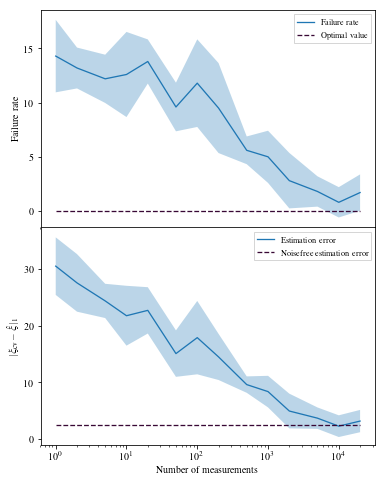

In [6]:
fs = plt.rcParams.get('figure.figsize')
fs[1] = 2*fs[1]
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=fs, sharex=True)

failure_rates = []
failure_rates_std = []
for gillespie_realization in range(len(gillespie_realizations)):
    estimated_rates = rates[gillespie_realization]
    r = [case_config.failure_rate(x) for x in estimated_rates]
    failure_rates.append(np.mean(r))
    failure_rates_std.append(np.std(r))

failure_rates = np.array(failure_rates)
failure_rates_std = np.array(failure_rates_std)
ax1.plot(gillespie_realizations, failure_rates, label='Failure rate')
ax1.fill_between(gillespie_realizations, y1=failure_rates-failure_rates_std, y2=failure_rates+failure_rates_std, alpha=0.3)
ax1.plot(gillespie_realizations, [0]*len(gillespie_realizations), '--', color='xkcd:eggplant', label='Optimal value')
ax1.set_xscale('log')
# ax1.set_xlabel('Number of measurements')
ax1.set_ylabel('Failure rate')
ax1.legend()

mean = np.mean(l1_dev, axis=1)
err = np.std(l1_dev, axis=1) #/ np.sqrt(10.) # 10 iids
ax2.plot(gillespie_realizations, mean, label=r'Estimation error')
ax2.fill_between(gillespie_realizations, y1=np.clip(mean-err, 0., 1e16), y2=mean+err, alpha=0.3)
ax2.set_xscale("log")
ax2.set_xlabel("Number of measurements")
ax2.set_ylabel(r"$|\xi_\mathrm{cv}-\hat{\xi}|_1$")
# plt.title("Deviation of estimated rates from desired rates")
ymin, ymax = plt.ylim()
ax2.set_ylim(-1,ymax)
ax2.plot(gillespie_realizations, [case_config.CASE1_MIN_L1_ERR]*len(gillespie_realizations), 
         '--', color='xkcd:eggplant', label='Noisefree estimation error')
ax2.legend()

f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

f.savefig("case2.pdf", bbox_inches="tight", transparent=True)
plt.style.use("lm.mplstyle")

In [8]:
if False:
    mean = np.mean(alpha_val, axis=1)
    err = np.std(alpha_val, axis=1) #/ np.sqrt(10.) # 10 iids
    plt.plot(gillespie_realizations, mean)
    plt.fill_between(gillespie_realizations, y1=np.clip(mean-err, 1e-8, 1.), y2=mean+err, alpha=0.3)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Number of measurements")
    plt.ylabel(r"Hyperparameter $\alpha$")
    # plt.title("Optimal hyperparameter after validation")
    #ymin, ymax = plt.ylim()
    #plt.ylim(-1,ymax)
    plt.savefig("case2_best_hyperparameter_averagefolds.pdf", bbox_inches="tight", transparent=True)